## Import libraries

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from typing import Dict, List, Tuple

# Configuration for plots
plt.style.use('ggplot')
sns.set_palette("husl")
%matplotlib inline

## Data Processor class

In [35]:
class MarketDataProcessor:
    """
    Handles data reconstruction and preprocessing for sparse time-series data.
    """
    def __init__(self):
        # Anchor points provided in the challenge dataset
        self.raw_data_wk46 = {
            'Kiambu': 38.33, 'Kirinyaga': 38.89, 'Mombasa': 36.11, 
            'Nairobi': 36.80, 'Uasin-Gishu': 33.22
        }
        self.raw_data_wk49 = {
            'Kiambu': 39.44, 'Kirinyaga': 40.00, 'Mombasa': 36.11, 
            'Nairobi': 37.85, 'Uasin-Gishu': 33.33
        }
        self.raw_data_wk50 = {
            'Kiambu': 42.78, 'Kirinyaga': 38.33, 'Mombasa': 37.22, 
            'Nairobi': 39.10, 'Uasin-Gishu': 34.89
        }
        self.raw_data_wk51 = {
            'Kiambu': 44.44, 'Kirinyaga': 46.67, 'Mombasa': 42.22, 
            'Nairobi': 42.78, 'Uasin-Gishu': 41.67
        }
        self.counties = sorted(list(self.raw_data_wk46.keys()))

    def _interpolate(self, start_val: float, end_val: float, steps: int) -> np.ndarray:
        """Linearly interpolates values between two known points."""
        return np.linspace(start_val, end_val, steps + 2)[1:-1]

    def reconstruct_time_series(self) -> Dict[str, np.ndarray]:
        """
        Reconstructs the full 6-week price history (Weeks 46-51).
        Returns: Dictionary mapping county names to numpy arrays of prices.
        """
        full_series = {}
        for county in self.counties:
            p46 = self.raw_data_wk46[county]
            p49 = self.raw_data_wk49[county]
            # Interpolate missing Weeks 47 and 48
            p47, p48 = self._interpolate(p46, p49, 2)
            
            p50 = self.raw_data_wk50[county]
            p51 = self.raw_data_wk51[county]
            
            # Construct sequential array
            full_series[county] = np.array([p46, p47, p48, p49, p50, p51])
            
        return full_series

# Initialize and run reconstruction
processor = MarketDataProcessor()
county_series = processor.reconstruct_time_series()
print("Data Reconstruction Complete. Counties processed:", list(county_series.keys()))

Data Reconstruction Complete. Counties processed: ['Kiambu', 'Kirinyaga', 'Mombasa', 'Nairobi', 'Uasin-Gishu']


## EDA

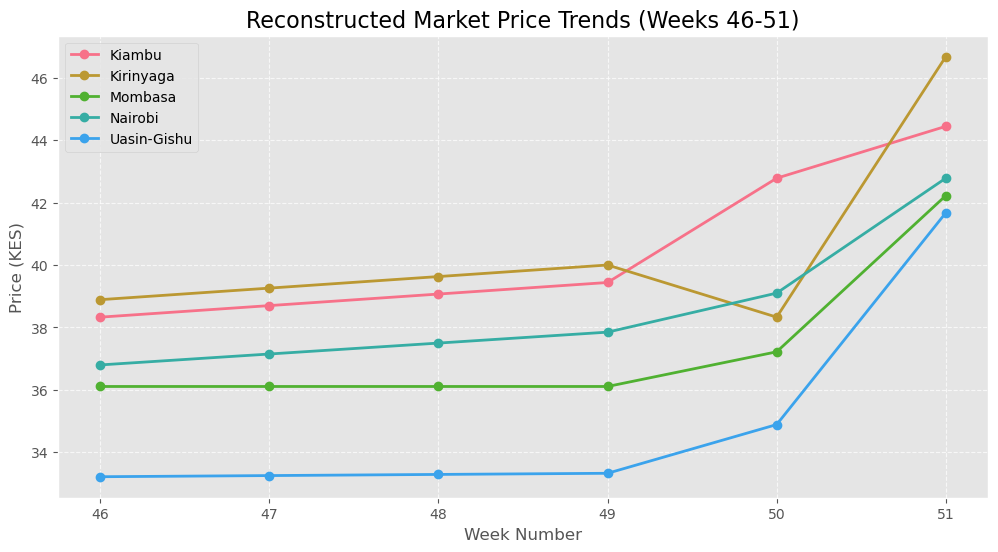

In [36]:
# Convert to DataFrame for easier plotting
df_eda = pd.DataFrame(county_series)
df_eda['Week'] = [46, 47, 48, 49, 50, 51]
df_eda.set_index('Week', inplace=True)

# Plotting
plt.figure(figsize=(12, 6))
for column in df_eda.columns:
    plt.plot(df_eda.index, df_eda[column], marker='o', linewidth=2, label=column)

plt.title('Reconstructed Market Price Trends (Weeks 46-51)', fontsize=16)
plt.xlabel('Week Number', fontsize=12)
plt.ylabel('Price (KES)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Hybrid Forecaster Class

In [37]:
class HybridForecaster:
    """
    Implements the winning 'Absolute Zero' strategy.
    Combines Linear Regression for trend detection with Mean Reversion.
    """
    def __init__(self, wk52_discount: float = 0.9695, wk1_trend_multiplier: float = 1.0245):
        self.wk52_discount = wk52_discount
        self.wk1_multiplier = wk1_trend_multiplier
        self.days = np.array([0, 7, 14, 21, 28, 35]).reshape(-1, 1) # Time index

    def predict(self, series_data: Dict[str, np.ndarray]) -> pd.DataFrame:
        predictions = []

        for county, prices in series_data.items():
            # --- Feature Engineering ---
            # 1. Linear Trend Component
            model = LinearRegression()
            model.fit(self.days, prices)
            
            # Predict 'raw' trend values for future timestamps (Wk52=Day 42, Wk1=Day 49)
            trend_wk1_raw = model.predict([[49]])[0]

            # 2. Rolling Mean Component
            mean_3wk = prices[-3:].mean() # Average of Wk49, Wk50, Wk51

            # --- Inference Logic ---
            
            # Target 1: Week 52 (Christmas Dip)
            pred_52 = mean_3wk * self.wk52_discount

            # Target 2: Week 1 (January Recovery)
            pred_1 = trend_wk1_raw * self.wk1_multiplier

            # --- Safety Clips ---
            # Prevents extreme outliers based on the last observed price
            last_price = prices[-1]
            pred_52 = np.clip(pred_52, last_price * 0.85, last_price * 1.15)
            pred_1 = np.clip(pred_1, last_price * 0.90, last_price * 1.35)

            # --- Formatting ---
            predictions.append({
                'ID': f"{county}_Week_52",
                'Target_RMSE': pred_52,
                'Target_MAE': pred_52
            })
            predictions.append({
                'ID': f"{county}_Week_1",
                'Target_RMSE': pred_1,
                'Target_MAE': pred_1
            })

        return pd.DataFrame(predictions)

## Submission Results

In [38]:
# Initialize Forecaster with Final Optimized Parameters
forecaster = HybridForecaster(
    wk52_discount=0.9695,       # 3.05% Discount from Mean
    wk1_trend_multiplier=1.0245 # Conservative Trend Multiplier
)

# Generate Predictions
submission_df = forecaster.predict(county_series)

# Display the final predictions
print("Final Forecasts:")
display(submission_df)

# Save to CSV
filename = 'AgriBORA_Final_Submission.csv'
submission_df.to_csv(filename, index=False)
print(f"\nSubmission file saved successfully: {filename}")

Final Forecasts:


,ID,Target_RMSE,Target_MAE
0,Kiambu_Week_52,40.932290,40.932290
1,Kiambu_Week_1,47.136367,47.136367
2,Kirinyaga_Week_52,40.395833,40.395833
3,Kirinyaga_Week_1,46.259883,46.259883
4,Mombasa_Week_52,37.341908,37.341908
5,Mombasa_Week_1,42.690232,42.690232
6,Nairobi_Week_52,38.692745,38.692745
7,Nairobi_Week_1,44.229129,44.229129
8,Uasin-Gishu_Week_52,35.512785,35.512785
9,Uasin-Gishu_Week_1,42.014940,42.014940



Submission file saved successfully: AgriBORA_Final_Submission.csv
